In [1]:
!pip install clearml
!pip install split-folders

  Using cached clearml-1.13.2-py2.py3-none-any.whl.metadata (16 kB)
  Using cached furl-2.1.3-py2.py3-none-any.whl (20 kB)
  Using cached pathlib2-2.3.7.post1-py2.py3-none-any.whl (18 kB)
  Using cached PyJWT-2.8.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached orderedmultidict-1.0.1-py2.py3-none-any.whl (11 kB)
Using cached clearml-1.13.2-py2.py3-none-any.whl (1.1 MB)
Using cached PyJWT-2.8.0-py3-none-any.whl (22 kB)
  Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import os
import shutil
import splitfolders
import pandas as pd
import numpy as np
from tqdm import tqdm
from colorama import Fore

In [3]:
IMAGE_PATH = "D:/Final year Project/data/images/images" # The path to the folder with images.
TARGET_PATH = "D:/Final year Project/data/annotation/annotation/YOLO-format" # The path to the folder with the annotation (labels). 

In [25]:
def create_dataset(data_path: str, target_path: str) -> pd.DataFrame:
    assert isinstance(data_path, str) 
    assert isinstance(target_path, str)
    
    dict_paths = {
        "image": [],
        "annotation": []
    }
    
    for dir_name, _, filenames in os.walk(data_path):
        for filename in tqdm(filenames):
            name = filename.split('.')[0]
            dict_paths["image"].append(f"{data_path}/{name}.jpg")
            dict_paths["annotation"].append(f"{target_path}/{name}.txt")

    
    dataframe = pd.DataFrame(
        data=dict_paths,
        index=np.arange(0, len(dict_paths["image"]))
    )
    
    return dataframe

In [26]:
def prepare_dirs(dataset_path: str,
                 annotation_path: str,
                 images_path: str) -> None:
    if not os.path.exists(dataset_path):
        os.mkdir(path=dataset_path)
        os.mkdir(path=annotation_path)
        os.mkdir(path=images_path)

In [27]:
def copy_dirs(dataframe: pd.DataFrame, 
             data_path: str,
             target_path: str) -> None:
    
    assert isinstance(dataframe, pd.DataFrame)
    assert isinstance(data_path, str) 
    assert isinstance(target_path, str)
    
    for i in tqdm(range(len(dataframe))):
        image_path, annotation_path = dataframe.iloc[i]
        shutil.copy(image_path, data_path)
        shutil.copy(annotation_path, target_path)

In [28]:
def finalizing_preparation(dataset_path: str, ladd_path: str):
    assert os.path.exists(f"{dataset_path}")
    
    example_structure = [
        "dataset", 
        "train", "labels", "images",
        "test","labels", "images",
        "val", "labels", "images"
    ]
    
    dir_bone = (
        dirname.split("/")[-1]
        for dirname, _, filenames in os.walk('D:/Final year Project/dataset')
        if dirname.split("/")[-1] in example_structure
    )
    
    try:
        print("\n~ Lacmus Dataset Structure ~\n")
        print(
        f"""
        ├── {next(dir_bone)}
        │   │
        │   ├── {next(dir_bone)}
        │   │   └── {next(dir_bone)}
        │   │   └── {next(dir_bone)}
        │   │        
        │   │        
        │   ├── {next(dir_bone)}
        │   │   └── {next(dir_bone)}
        │   │   └── {next(dir_bone)}
        │   │
        │   ├── {next(dir_bone)}
        │   │   └── {next(dir_bone)}
        │   │   └── {next(dir_bone)}
     
        """
        )
    except StopIteration as e:
        print(e)
    else:
        print(Fore.GREEN + "-> Success")
    finally:
        os.system(f"rm -rf {ladd_path}")

In [29]:
df = create_dataset(
    data_path=IMAGE_PATH,
    target_path=TARGET_PATH
)

100%|██████████| 1365/1365 [00:00<00:00, 88304.54it/s]


In [30]:
dataset_path = "D:/Final year Project/dataset"
ladd_path = "D:/Final year Project/ladd"
annotation_path = "D:/Final year Project/ladd/labels"
image_path = "D:/Final year Project/ladd/images"

In [31]:
prepare_dirs(
    dataset_path=ladd_path,
    annotation_path=annotation_path,
    images_path=image_path
)

In [32]:
copy_dirs(
    dataframe=df, 
    data_path=image_path,
    target_path=annotation_path
)

100%|██████████| 1365/1365 [00:17<00:00, 78.09it/s] 


In [33]:
splitfolders.ratio(
    input=ladd_path,
    output=dataset_path,
    seed=42,
    ratio=(0.80, 0.10, 0.10),
    group_prefix=None,
    move=True
) 

Copying files: 2730 files [00:01, 1802.97 files/s]


In [34]:
finalizing_preparation(
    dataset_path,
    ladd_path
)


~ Lacmus Dataset Structure ~




In [4]:
import torch

torch.cuda.set_device(0)

In [5]:
import yaml
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [6]:
config = {
    "path": "D:/Final year Project/dataset",
    "train": "D:/Final year Project/dataset/train/images",
    "val": "D:/Final year Project/dataset/val/images",
    "predict": "D:/Final year Project/test/train/images",
    "nc": 1,
    "names": ["human"]
}

with open("config.yaml", "w") as f:
    yaml.dump(config, f)

with open("config.yaml", "r") as f:
    print(f.read())

names:
- human
nc: 1
path: D:/Final year Project/dataset
predict: D:/Final year Project/test/train/images
train: D:/Final year Project/dataset/train/images
val: D:/Final year Project/dataset/val/images



In [7]:
def main():
    model = YOLO("yolov8n.pt")
    model.train(
        # Project
        project="Polar-Owl",
        name="yolov8n",

        # Random Seed parameters
        deterministic=True,
        seed=42,

        # Data & model parameters
        data="D:/Final year Project/config.yaml", 
        save=True,
        save_period=5,
        pretrained=True,
        imgsz=1280,

        # Training parameters
        epochs=50,
        batch=4,
        workers=8,
        val=True,
        device=0,

        # Optimization parameters
        lr0=0.0195,
        patience=3,
        optimizer="SGD",
        momentum=0.957,
        weight_decay=0.0005,
        close_mosaic=5,
    )




In [8]:
if __name__ == '__main__':
    main()

New https://pypi.org/project/ultralytics/8.1.29 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.222 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/Final year Project/config.yaml, epochs=50, patience=3, batch=4, imgsz=1280, save=True, save_period=5, cache=False, device=0, workers=8, project=Polar-Owl, name=yolov8n2, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=5, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=Fals

train: Scanning D:\Final year Project\dataset\train\labels.cache... 1092 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1092/1092 [00:00<?, ?it/s]
val: Scanning D:\Final year Project\dataset\val\labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]


Plotting labels to Polar-Owl\yolov8n2\labels.jpg... 
optimizer: SGD(lr=0.0195, momentum=0.957) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to Polar-Owl\yolov8n2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.92G      1.781      2.512      0.992         34       1280: 100%|██████████| 273/273 [01:30<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.20it/s]

                   all        136        606      0.628      0.429      0.457       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.25G      1.899      1.856      1.021          8       1280: 100%|██████████| 273/273 [01:29<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.97it/s]

                   all        136        606      0.669      0.545      0.549      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.26G      2.165      2.168      1.118         21       1280: 100%|██████████| 273/273 [01:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.66it/s]


                   all        136        606      0.396     0.0875     0.0952     0.0308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.37G      2.247      2.079      1.148         10       1280: 100%|██████████| 273/273 [01:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.93it/s]

                   all        136        606       0.61      0.469      0.489      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.25G      2.084      1.721      1.106         12       1280: 100%|██████████| 273/273 [01:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.70it/s]

                   all        136        606      0.729      0.464      0.536      0.229
Stopping training early as no improvement observed in last 3 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



5 epochs completed in 0.128 hours.
Optimizer stripped from Polar-Owl\yolov8n2\weights\last.pt, 6.4MB
Optimizer stripped from Polar-Owl\yolov8n2\weights\best.pt, 6.3MB

Validating Polar-Owl\yolov8n2\weights\best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.02it/s]


                   all        136        606      0.669      0.544      0.549      0.257
Speed: 0.9ms preprocess, 8.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to Polar-Owl\yolov8n2


In [9]:
from os import listdir

listdir("D:/Final year Project/dataset/test/images")

['1009.jpg',
 '1018.jpg',
 '1043.jpg',
 '1046.jpg',
 '1052.jpg',
 '1056.jpg',
 '1077.jpg',
 '1081.jpg',
 '1084.jpg',
 '110.jpg',
 '1114.jpg',
 '1119.jpg',
 '1125.jpg',
 '1129.jpg',
 '1142.jpg',
 '1144.jpg',
 '1158.jpg',
 '1165.jpg',
 '1168.jpg',
 '117.jpg',
 '1176.jpg',
 '1183.jpg',
 '1186.jpg',
 '12.jpg',
 '1202.jpg',
 '1208.jpg',
 '1227.jpg',
 '1252.jpg',
 '1254.jpg',
 '1260.jpg',
 '128.jpg',
 '1284.jpg',
 '1291.jpg',
 '1292.jpg',
 '1298.jpg',
 '1299.jpg',
 '1312.jpg',
 '1351.jpg',
 '1364.jpg',
 '156.jpg',
 '159.jpg',
 '161.jpg',
 '166.jpg',
 '172.jpg',
 '174.jpg',
 '176.jpg',
 '181.jpg',
 '19.jpg',
 '192.jpg',
 '199.jpg',
 '220.jpg',
 '224.jpg',
 '232.jpg',
 '254.jpg',
 '257.jpg',
 '258.jpg',
 '261.jpg',
 '263.jpg',
 '267.jpg',
 '277.jpg',
 '282.jpg',
 '302.jpg',
 '31.jpg',
 '35.jpg',
 '351.jpg',
 '368.jpg',
 '390.jpg',
 '397.jpg',
 '403.jpg',
 '424.jpg',
 '431.jpg',
 '436.jpg',
 '437.jpg',
 '442.jpg',
 '452.jpg',
 '468.jpg',
 '47.jpg',
 '470.jpg',
 '473.jpg',
 '48.jpg',
 '5.jpg',
 

In [10]:
model = YOLO("D:/Final year Project/Polar-Owl/yolov8n/weights/best.pt")

In [11]:
history = model.predict("D:/Final year Project/dataset/test/images/549.jpg")[0]
image = history.orig_img


image 1/1 D:\Final year Project\dataset\test\images\549.jpg: 736x1280 2 humans, 128.9ms
Speed: 11.0ms preprocess, 128.9ms inference, 14.0ms postprocess per image at shape (1, 3, 736, 1280)


In [12]:
Xmin1, Ymin1, Xmax1, Ymax1, conf1, _ = history.boxes.data[0].cpu().numpy()

W1 = Xmax1 - Xmin1 
H1 = Ymax1 - Ymin1

In [13]:
Xmin2, Ymin2, Xmax2, Ymax2, conf2, _ = history.boxes.data[1].cpu().numpy()

W2 = Xmax2 - Xmin2 
H2 = Ymax2 - Ymin2

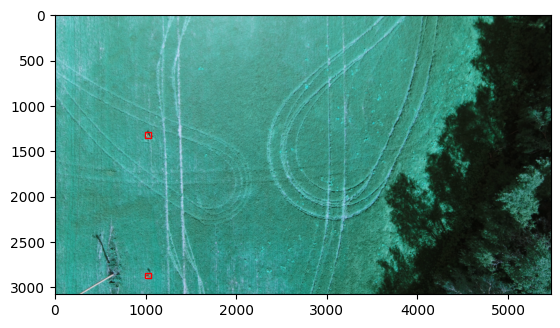

In [14]:
%matplotlib inline
plt.imshow(image)

plt.gca().add_patch(
    Rectangle([Xmin1, Ymin1], W1, H1,
              edgecolor='red',
              facecolor='none',
              lw=1)
)

plt.gca().add_patch(
    Rectangle([Xmin2, Ymin2], W2, H2,
              edgecolor='red',
              facecolor='none',
              lw=1)
)

plt.show()

In [ ]:
history = model.predict("D:/Final year Project/dataset/test/images/220.jpg", conf=0.5)[0]
image = history.plot()
plt.imshow(image)
plt.show()

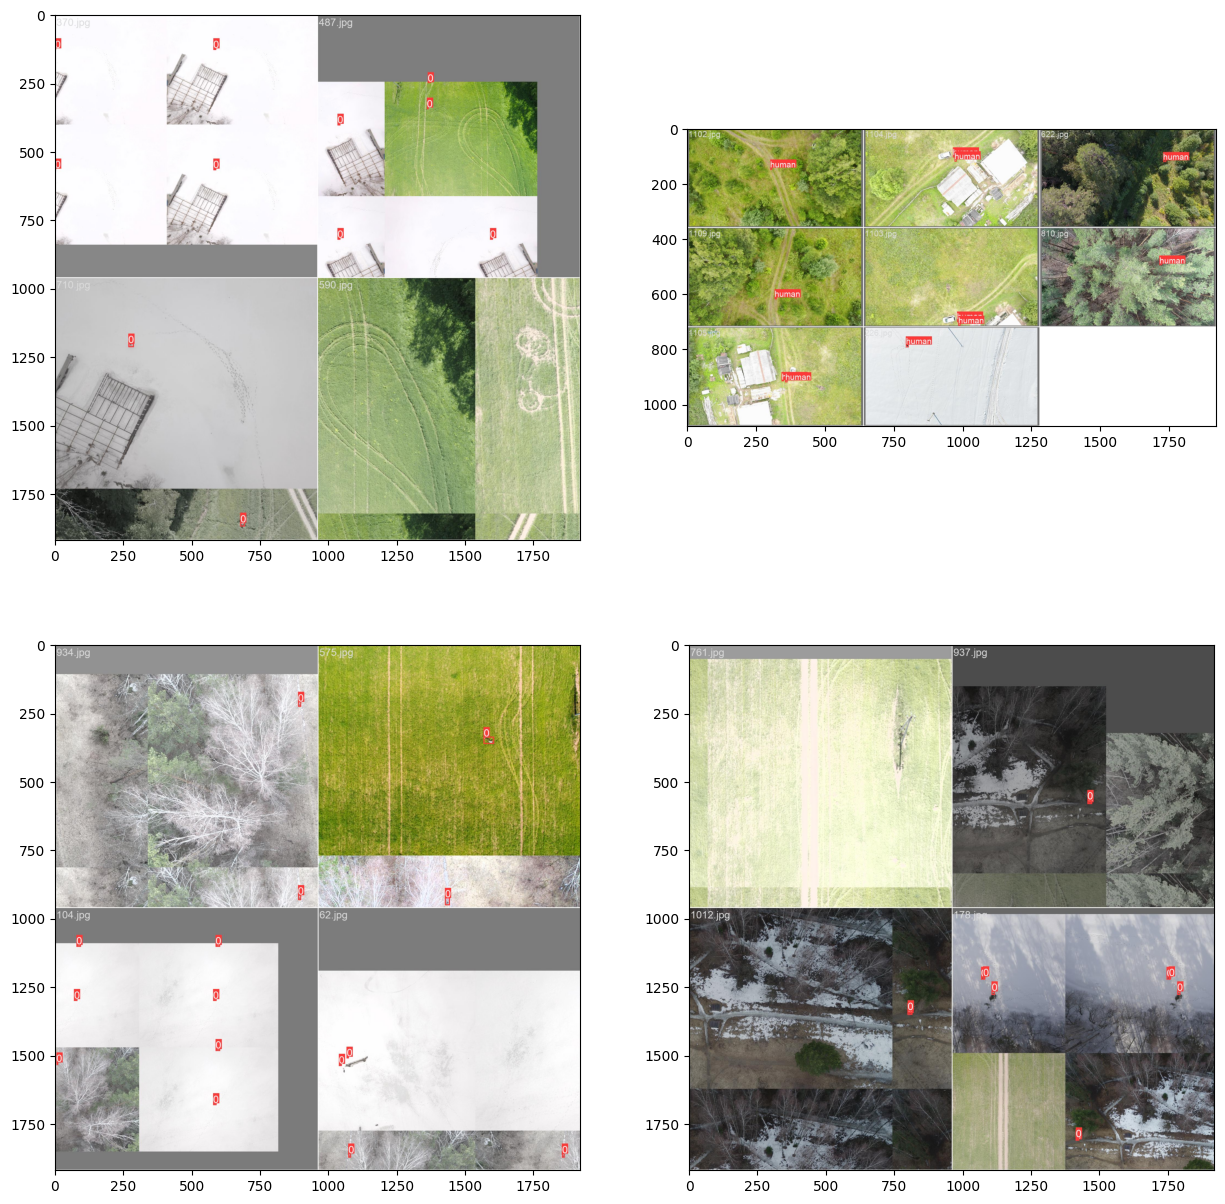

In [16]:
batch1 = Image.open("D:/Final year Project/Polar-Owl/yolov8n/train_batch0.jpg")
batch2 = Image.open("D:/Final year Project/Polar-Owl/yolov8n/val_batch0_labels.jpg")
batch3 = Image.open("D:/Final year Project/Polar-Owl/yolov8n/train_batch1.jpg")
batch4 = Image.open("D:/Final year Project/Polar-Owl/yolov8n/train_batch2.jpg")

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(15, 15)
axes[0][0].imshow(batch1)
axes[0][1].imshow(batch2)
axes[1][0].imshow(batch3)
axes[1][1].imshow(batch4)
plt.show()

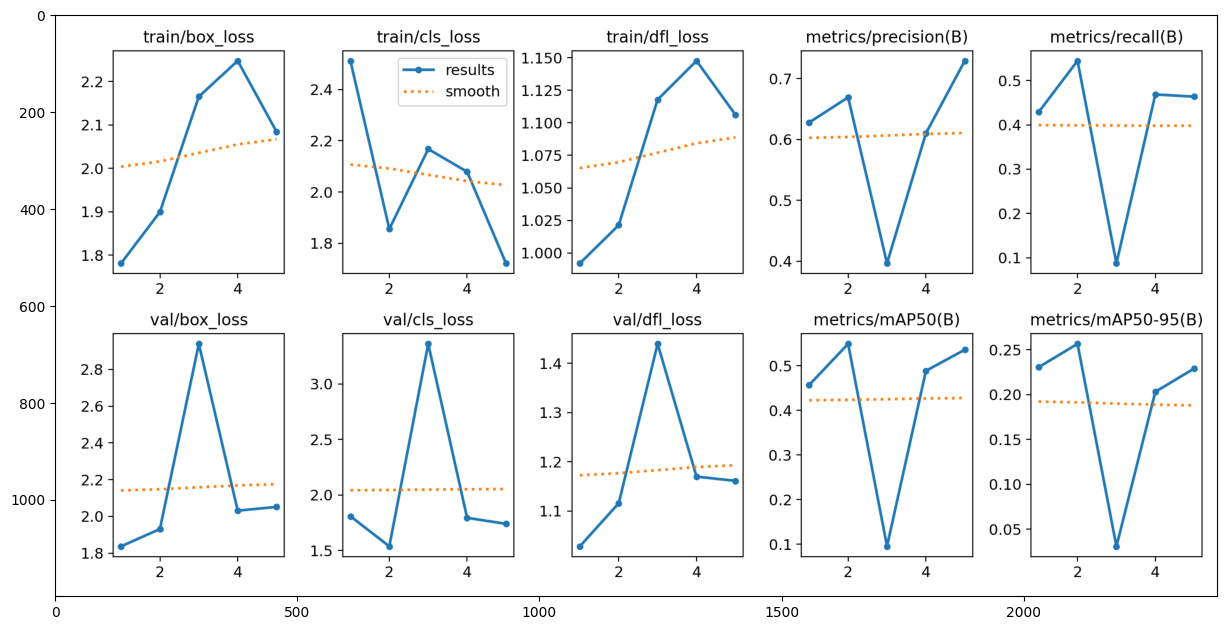

In [17]:
results = Image.open("D:/Final year Project/Polar-Owl/yolov8n/results.png")
plt.figure(figsize=(15, 20))
plt.imshow(results)
plt.show()

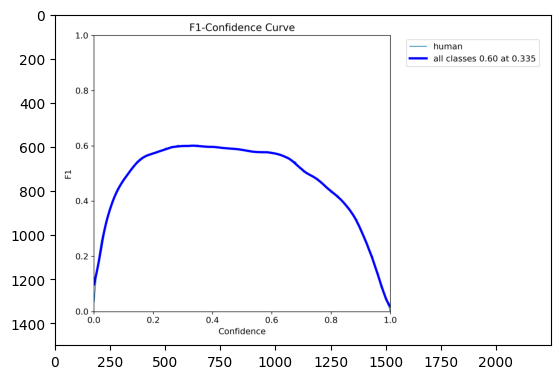

In [18]:
F1_curve = Image.open("D:/Final year Project/Polar-Owl/yolov8n/F1_curve.png")
plt.imshow(F1_curve)
plt.show()

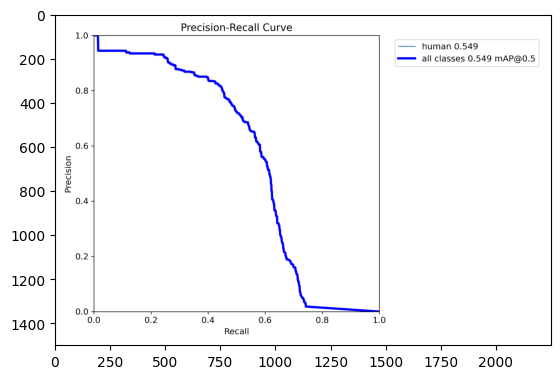

In [19]:
PR_curve = Image.open("D:/Final year Project/Polar-Owl/yolov8n/PR_curve.png")
plt.imshow(PR_curve)
plt.show()

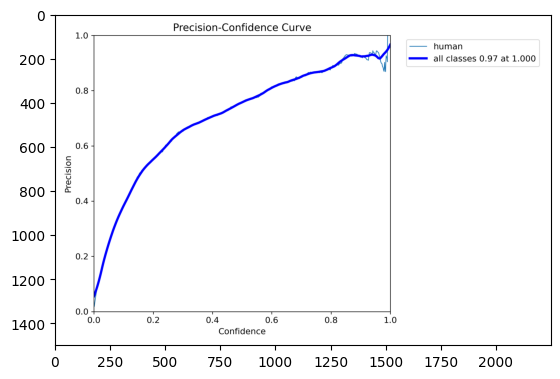

In [20]:
P_curve = Image.open("D:/Final year Project/Polar-Owl/yolov8n/P_curve.png")
plt.imshow(P_curve)
plt.show()

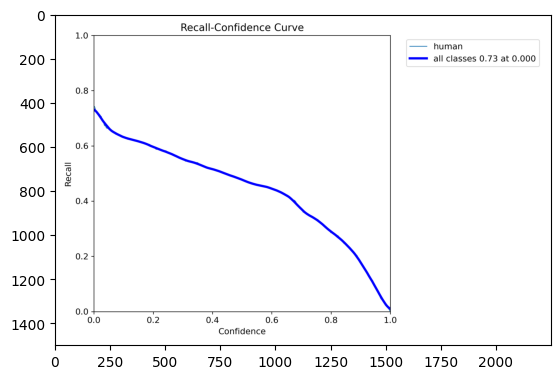

In [21]:
R_curve = Image.open("D:/Final year Project/Polar-Owl/yolov8n/R_curve.png")
plt.imshow(R_curve)
plt.show()